In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import seaborn as sns

# 1. Binary Logistic

$$
p(y=1|x) = \sigma(w^Tx) = \frac{1}{1 + e^{-w^Tx}} \\
 \\
p(y=0|x) = 1 - p(y=1|x)
 \\
$$

Therefore, $y_n \sim Bern(n, p_n)$

$$
p(y_n= y|x_n) = p_n^{y_n} (1 - p_n)^{1 - y_n} = \sigma(w \cdot x_n)^{y_n} (1 - \sigma(w \cdot x_n))^{1 - y_n}
$$

The negative log-likelihood function is

$$
NLL(\theta) = -\sum^N  y_n log(p(x_n)) - (1 - y_n)log(1 - p(x_n)) \\
$$

In [199]:
def logistic(z):
    return 1 / (1 + np.exp(-z))


class BinaryLogistic:
    def __init__(self):
        pass

    def fit(self, X, y, ln=0.001, iters=10):
        N, D = X.shape

        theta_hat = np.random.randn(D)
        for i in range(iters):
            # print('BCE', self.crossEntropyLoss(X, y, theta_hat))

            p = logistic(X @ theta_hat)
            grad = X.T @ (p - y)
            theta_hat -= ln * grad

        self.theta_hat = theta_hat

    def crossEntropyLoss(self, X, y, theta):
        """
        Negative Loss function
        """
        epsilon = 1e-12

        p = logistic(X @ theta)

        cost = -np.average(y * np.log(p + epsilon) + (1 - y) * np.log(1 - p + epsilon))

        return cost

    def predict_prob(self, X_test):
        return logistic(X_test @ self.theta_hat)


    def prob(self, X_test):
        self.p = logistic(X_test @ self.theta_hat)
        return self.p.round()


## Example

In [200]:
digits = datasets.load_digits(2) # binary classificatin (0 or 1)

X, y = digits.data, digits.target
X = np.c_[np.ones(X.shape[0]), X]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28)

X_train.shape, y_train.shape, X_test.shape


/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_class=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


((259, 65), (259,), (101, 65))

In [201]:

binary_model = BinaryLogistic()

binary_model.fit(X_train, y_train)

binary_model.theta_hat


array([ 0.01209538,  0.61562571,  1.81039831, -1.63240167, -0.52373471,
        0.83368693, -0.46934796,  0.47080822,  0.6584371 , -0.16224037,
       -1.45067083, -1.55163918, -0.35249545,  1.57851733,  0.10597435,
        0.93061975, -0.37400327,  0.39588083, -0.1030568 , -1.55705591,
        1.57840998,  2.36820344, -2.98108271, -0.22183238, -0.19227683,
       -0.53630661,  0.06387335, -2.4360591 ,  3.19632611,  1.11572039,
        0.06848294, -0.00456664,  1.32242242, -1.08181668, -1.63163586,
        1.27347108,  1.29291572,  1.96479462, -0.36116229, -0.45952579,
       -1.19948059,  0.38322784, -0.71000202, -1.39365565,  1.63166831,
        1.76903609,  0.64669718,  0.52312199,  0.96492825,  0.26799377,
        0.99711758, -0.73220307, -0.44825737,  1.02457485, -3.51778207,
        0.68997724, -0.44680532,  1.13365704, -0.30658709, -2.97462035,
       -1.073388  , -0.06014906,  2.17104253, -0.70820775,  0.93278177])

In [202]:
print('correct num', np.sum(binary_model.prob(X_test) == y_test))

print('accuracy', np.mean(binary_model.prob(X_test) == y_test))

binary_model.crossEntropyLoss(X_test, y_test, binary_model.theta_hat)


correct num 100
accuracy 0.9900990099009901


0.12640249232312295

(array([[51.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 50.]]),
 array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 <a list of 2 BarContainer objects>)

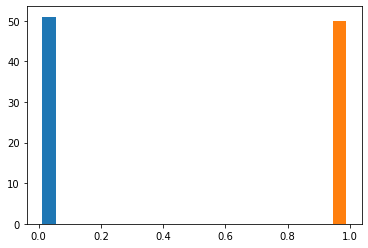

In [203]:
yhat = binary_model.prob(X_test)

fig, ax = plt.subplots()
bins = np.linspace(0, 1, 10)
ax.hist([binary_model.p[yhat == 0], binary_model.p[yhat == 1]], bins)


# 2. Softmax Regression

$$
y_i = \left[\matrix{y_{i1}\\y_{i2}\\...\\y_{ik}}\right] \rightarrow Softmax \rightarrow \left[\matrix{p_{i1}\\p_{i2}\\...\\p_{ik}}\right]
\\
L(\theta) = - \left[ \sum_{i=1}^{m} \sum_{k=1}^{K}  1\left\{y_{i} = k\right\} \log \frac{\exp(\theta^{(k)\top} \mathbf{x}_i)}{\sum_{j=1}^K \exp(\theta^{(j)\top} \mathbf{x}_i)}\right]
\\
\nabla_{\theta^{(k)}} L(\theta) = - \sum_{i=1}^{m}{ \left[ \mathbf{x}_i \left( 1\{ y_i = k\}  - P(y_i = k | \mathbf{x}_i; \theta) \right) \right]  }
$$

In [204]:
"""
X = N x D
theta = D x K
y, N x K, one hot encoding

Z = X @ theta, N x K
"""

def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

def softmax(Z):
    return np.exp(Z) / np.exp(Z).sum(1).reshape(-1, 1)


class MultiLogistic:
    def __init__(self, lr=0.01):
        self.lr = lr

    def softmax_loss(self, X, y, theta):
        p = softmax(X @ theta)
        return -np.trace(np.log(p) @ y.T)


    def softmax_gradient(self, X, y, theta):
        p = softmax(X @ theta)
        return -X.T @(y - p)

    def fit(self, X_train, y_train):
        N, D = X_train.shape
        _, K = y_train.shape

        iters = 2000        
        theta_gd = np.random.randn(D, K)
        for i in range(iters):
            gr = self.softmax_gradient(X_train, y_train, theta_gd)
            theta_gd -= self.lr * gr

            if i%100 == 0:
                print("Training Loss: ", self.softmax_loss(X_train, y_train, theta_gd))

        self.theta_gd = theta_gd

    def predict(self, X_test, y_test):
        # Compute the accuracy of the test set
        proba = softmax(X_test @ self.theta_gd) # N by K

        acc = sum(proba.argmax(1) == y_test) / float(proba.shape[0])
        
        print('accuracy:', acc)


## Example 1

In [205]:
digits = datasets.load_digits(10) 

X, y = digits.data, digits.target
X = np.c_[np.ones(X.shape[0]), X]

# scale [0, 1]
X /= 255 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28)
y_train = get_one_hot(y_train, 10)

X_train.shape, y_train.shape, X_test.shape


/Users/wuxiaopan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_class=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


((1293, 65), (1293, 10), (504, 65))

In [206]:
lcl = MultiLogistic()

lcl.fit(X_train, y_train)

lcl.predict(X_test, y_test)


Training Loss:  3035.7799852079615
Training Loss:  2000.2502346684173
Training Loss:  1441.2979358181376
Training Loss:  1126.5303765400201
Training Loss:  933.8435997623195
Training Loss:  805.8505422436833
Training Loss:  715.0682991572419
Training Loss:  647.3267040337837
Training Loss:  594.7456926003338
Training Loss:  552.6451474058978
Training Loss:  518.0875917307092
Training Loss:  489.14212638473197
Training Loss:  464.4892163568101
Training Loss:  443.1969210744782
Training Loss:  424.5882450263495
Training Loss:  408.1593102695636
Training Loss:  393.5270961415689
Training Loss:  380.3950301166458
Training Loss:  368.5297147720746
Training Loss:  357.7448065632285
accuracy: 0.9305555555555556


## Example 2

In [207]:
wine = datasets.load_wine()
X = wine['data']
y = wine['target']

def standard_scaler(X):
    mean = X.mean(0)
    sd = X.std(0)
    return (X - mean)/sd 


X = standard_scaler(X) 
X_train = np.c_[np.ones(X.shape[0]), X]
y_train = get_one_hot(y, len(np.unique(y)))

X_train.shape, y_train.shape


((178, 14), (178, 3))

In [208]:
lcl = MultiLogistic(lr=0.001)

lcl.fit(X_train, y_train)

lcl.predict(X_train, y)


Training Loss:  260.46080992895486
Training Loss:  15.838267937540607
Training Loss:  8.715520814101755
Training Loss:  6.306106319340954
Training Loss:  5.075937135429375
Training Loss:  4.31303185922459
Training Loss:  3.784265582397425
Training Loss:  3.390906195007256
Training Loss:  3.083787835597212
Training Loss:  2.8355182056018737
Training Loss:  2.6295229311946007
Training Loss:  2.455119898758925
Training Loss:  2.305073972744593
Training Loss:  2.1742849656322543
Training Loss:  2.059038084789897
Training Loss:  1.956552985103311
Training Loss:  1.8647004491204298
Training Loss:  1.781817709370373
Training Loss:  1.7065842047422246
Training Loss:  1.637935674324483
accuracy: 1.0


# 3. One-vs-Rest

((100, 2), (100,))

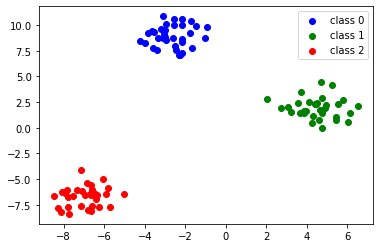

In [228]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

X, y = make_blobs(random_state=42)

color=['b', 'g', 'r']
for i in range(3):
    X_c = X[y==i]
    plt.scatter(X_c[:,:1], X_c[:,1:], label='class '+str(i), c=color[i])
plt.legend()

X.shape, y.shape


In [229]:
X_new = np.c_[np.ones(len(X)), X]

y0 = np.ones(len(X_new))
y0[y!=0] = 0

y1 = np.ones(len(X_new))
y1[y!=1] = 0

y2 = np.ones(len(X_new))
y2[y!=2] = 0


In [230]:
theta = np.empty((0, 3))
oneVsAllModels = []

for yi in [y0, y1, y2]:
    binary_model = BinaryLogistic()
    binary_model.fit(X_new, yi)
    theta = np.vstack([theta, binary_model.theta_hat])
    oneVsAllModels.append(binary_model)

theta

array([[-0.52565904, -0.26148419,  0.45981176],
       [-1.49698112,  1.74919947,  0.24014411],
       [-0.6513969 , -0.39349822, -0.45669994]])

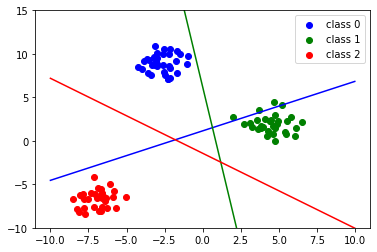

In [231]:
line = np.linspace(-10,10)

color=['b', 'g', 'r']
for i in range(3):
    X_c = X[y==i]
    plt.scatter(X_c[:,:1], X_c[:,1:], label='class '+str(i), c=color[i])

for i in range(3):
    intercept, a, b = theta[i]
    plt.plot(line, -(line * a + intercept) / b, c=color[i])

plt.ylim(-10, 15)
plt.legend()


In [232]:
def max_vote(X_test):
    prob = []
    for model in oneVsAllModels:
        prob.append(model.predict_prob(X_test))
    return np.argmax(prob, axis=0)

max_vote([[1, -5.0 , 5], [1, 5.0 , 5]])


array([0, 1])

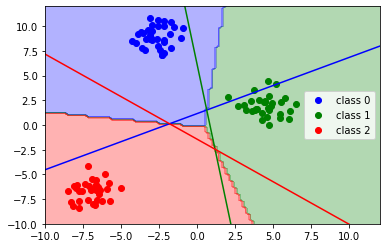

In [233]:
from matplotlib.colors import ListedColormap

axes=[-10, 12, -10, 12]
x1s = np.linspace(axes[0], axes[1], 100)
x2s = np.linspace(axes[2], axes[3], 100)
x1, x2 = np.meshgrid(x1s, x2s)
X_new = np.c_[np.ones(len(x1.ravel())), x1.ravel(), x2.ravel()]

y_pred = max_vote(X_new).reshape(x1.shape)

color=['b', 'g', 'r']
custom_cmap = ListedColormap(color)
plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

for i in range(3):
    X_c = X[y==i]
    plt.scatter(X_c[:,:1], X_c[:,1:], label='class '+str(i), c=color[i])

line = np.linspace(-10,12)
for i in range(3):
    intercept, a, b = theta[i]
    plt.plot(line, -(line * a + intercept) / b, c=color[i])

plt.ylim(-10, 12)
plt.legend()